In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# laod data

In [2]:
import os
import pandas as pd
import numpy as np 
directory = 'data/group3/config_1'#/config_3'
labels=[]
all_data=[]
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    data = pd.read_csv(f)
    all_data.append(np.array(data))
    # formatage des labels pour chaque pas de temps
    label = int(filename[0])
    labels.append(np.array([label]*len(data)).reshape(-1,1))
columns_name = pd.read_csv(os.path.join(directory, os.listdir(directory)[1])).columns.tolist()

# initialize the reservoir coomputing
* https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/5-Classification-with-RC.ipynb

In [3]:
import reservoirpy as rpy

rpy.verbosity(0.1) 
rpy.set_seed(42) 

In [4]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

## process label 
* we need one hot encoded matrice for classification
* we need a class for each time_step

In [5]:
####################################
### preprocessing y pour RC       ##
####################################


from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc_label = enc.fit_transform(np.array(label).reshape(-1,1)).toarray()

new_label=[]
for i in range(len(all_data)):
    new_label.append(np.tile(enc_label[i], (len(all_data[i]), 1)))

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
new_label[]

176

In [ ]:
n_train = len(all_data)//4
idx_test = np.random.choice(np.arange(len(all_data)), n_train)
idx_train = np.array( list(set(np.arange(len(all_data))) - set(idx_test)))

X_train, X_test = [all_data[i] for i in idx_train],  [all_data[i] for i in idx_test] 
y_train, y_test = [new_label[i] for i in idx_train],  [new_label[i] for i in idx_test]

esn_model = esn_model.fit(X_train, y_train, warmup=10)

print("reservoir initialize, ")
print(reservoir.is_initialized, ridge.is_initialized, ridge.fitted)

NameError: name 'new_label' is not defined

# predictions

In [ ]:
Y_pred = esn_model.run(X_test)

### on compatibilize

In [ ]:
res_ = []
preds=[]
for i in range(len(Y_pred)):
    for timestep in range(len(Y_pred[i])):
        u = np.zeros(10)
        u[np.argmax(Y_pred[i][timestep])] = 1
        res_.append(u)
    preds.append(np.argmax(pd.DataFrame(np.array(res_).T).sum(axis=1)))

In [ ]:
res_ = []
labels=[]
for i in range(len(y_test)):
    for timestep in range(len(y_test[i])):
        u = np.zeros(10)
        u[np.argmax(y_test[i][timestep])] = 1
        res_.append(u)
    labels.append(np.argmax(pd.DataFrame(np.array(res_).T).sum(axis=1)))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.67      0.50      0.57         4
           3       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.75      0.06      0.11        49

    accuracy                           0.09        55
   macro avg       0.28      0.11      0.14        55
weighted avg       0.72      0.09      0.14        55



/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.

<Axes: >

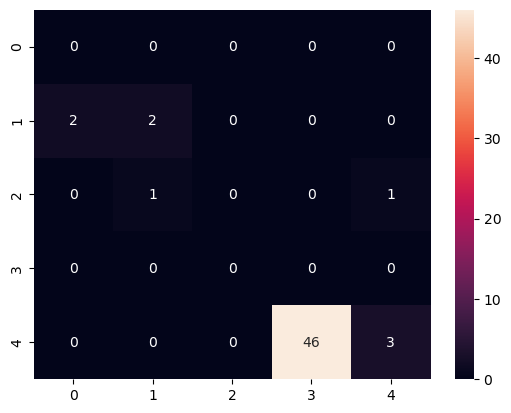

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import classification_report

print(accuracy_score(labels,preds))
print(classification_report(labels,preds))
sns.heatmap(confusion_matrix(labels,preds), fmt=".2g", annot=True)